In [24]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta



print(" Starting Part 1: EMERGENCY DATA GENERATION (No Dependencies)")


if not os.path.exists('data'):
    os.makedirs('data')
    print(" Created 'data/' directory.")


start_date = datetime.now() - timedelta(days=365)
end_date = datetime.now()
date_range = pd.date_range(start=start_date, end=end_date, freq='5T') # 5 min

# Filter for market hours (09:15 to 15:30)
market_data = pd.DataFrame({'timestamp': date_range})
market_data['time'] = market_data['timestamp'].dt.time
market_data = market_data[
    (market_data['time'] >= pd.to_datetime('09:15').time()) & 
    (market_data['time'] <= pd.to_datetime('15:30').time())
].copy()

# Filter for weekends (Sat/Sun)
market_data['day_of_week'] = market_data['timestamp'].dt.dayofweek
market_data = market_data[market_data['day_of_week'] < 5] # 0-4 is Mon-Fri

# Reset index
market_data.reset_index(drop=True, inplace=True)
n_rows = len(market_data)
print(f"Generating {n_rows} rows of data")


# Random walk for price logic
np.random.seed(42)
returns = np.random.normal(loc=0.0001, scale=0.002, size=n_rows)
price_path = 21000 * np.cumprod(1 + returns) # Start Nifty at 21,000

market_data['spot_open'] = price_path
market_data['spot_close'] = price_path * (1 + np.random.normal(0, 0.001, n_rows))
market_data['spot_high'] = market_data[['spot_open', 'spot_close']].max(axis=1) * (1 + np.random.uniform(0, 0.001, n_rows))
market_data['spot_low'] = market_data[['spot_open', 'spot_close']].min(axis=1) * (1 - np.random.uniform(0, 0.001, n_rows))
market_data['spot_volume'] = np.random.randint(10000, 100000, n_rows)

# Create specific Spot dataframe
nifty_spot = market_data[['timestamp', 'spot_open', 'spot_high', 'spot_low', 'spot_close', 'spot_volume']].copy()

# Save Spot Data
nifty_spot.to_csv('data/nifty_spot_5min.csv', index=False)
print(" Nifty Spot Data Generated")

nifty_futures = nifty_spot[['timestamp']].copy()
nifty_futures['fut_close'] = nifty_spot['spot_close'] + np.random.uniform(10, 50, n_rows) 
nifty_futures['fut_open'] = nifty_futures['fut_close'] * (1 + np.random.normal(0, 0.001, n_rows))
nifty_futures['fut_high'] = nifty_futures['fut_close'] * 1.001
nifty_futures['fut_low'] = nifty_futures['fut_close'] * 0.999
nifty_futures['fut_oi'] = np.random.randint(1000000, 1500000, size=n_rows)

nifty_futures.to_csv('data/nifty_futures_5min.csv', index=False)
print("Nifty Futures Data Generated")


nifty_options = nifty_spot[['timestamp']].copy()
# Dynamic ATM Strike Calculation: Round to nearest 50
nifty_options['atm_strike'] = (round(nifty_spot['spot_close'] / 50) * 50).astype(int)

# Mock Options Pricing & Greeks variables
nifty_options['ce_ltp'] = np.random.uniform(50, 200, n_rows)
nifty_options['pe_ltp'] = np.random.uniform(50, 200, n_rows)
nifty_options['ce_iv'] = np.random.uniform(10, 25, n_rows) # IV between 10-25%
nifty_options['pe_iv'] = np.random.uniform(10, 25, n_rows)
nifty_options['ce_oi'] = np.random.randint(50000, 500000, n_rows)
nifty_options['pe_oi'] = np.random.randint(50000, 500000, n_rows)
nifty_options['ce_volume'] = np.random.randint(1000, 10000, n_rows)
nifty_options['pe_volume'] = np.random.randint(1000, 10000, n_rows)

nifty_options.to_csv('data/nifty_options_5min.csv', index=False)
print(" Nifty Options Data Generated")

print("Merging data")

# Merge Spot and Futures on Timestamp
merged_df = pd.merge(nifty_spot, nifty_futures, on='timestamp')

# Merge with Options
merged_df = pd.merge(merged_df, nifty_options, on='timestamp')

# Save Final Merged Data
merged_df.to_csv('data/nifty_merged_5min.csv', index=False)

# Create the text report
with open('data/data_cleaning_report.txt', 'w') as f:
    f.write(f"Data Cleaning Report - {datetime.now()}\n")
    f.write(f"1. Generated clean mock data: {len(merged_df)} rows.\n")
    f.write("2. No outliers or missing values to handle (Data is synthetic).\n")
    f.write("3. Timestamps aligned across Spot, Futures, and Options.\n")

print("-" * 30)
print(f" FINAL MERGE COMPLETE. Total Rows: {len(merged_df)}")
print(f" Output saved to: data/nifty_merged_5min.csv")
print("-" * 30)

 Starting Part 1: EMERGENCY DATA GENERATION (No Dependencies)
Generating 19500 rows of data
 Nifty Spot Data Generated
Nifty Futures Data Generated
 Nifty Options Data Generated
Merging data
------------------------------
 FINAL MERGE COMPLETE. Total Rows: 19500
 Output saved to: data/nifty_merged_5min.csv
------------------------------


In [5]:
!pip install mibian


  Created wheel for mibian: filename=mibian-0.1.3-py3-none-any.whl size=4039 sha256=2d3bdad3af06a7b9a98227ac5ad81541ee1613e8830a9e8b6a172bf3ddbf6bdd
  Stored in directory: c:\users\puchu\appdata\local\pip\cache\wheels\43\b9\31\945abf284df5614e45ec4fccb8a892025987093558c94902fb
Successfully built mibian


In [25]:
import pandas as pd
import numpy as np
import mibian


print(" Part 2: Feature Engineering")
df = pd.read_csv('data/nifty_merged_5min.csv')

# timestamps are datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("[Task 2.1] Calculating EMAs...")
# EMA 5 (Fast) and EMA 15 (Slow) on Spot Close
df['ema_5'] = df['spot_close'].ewm(span=5, adjust=False).mean()
df['ema_15'] = df['spot_close'].ewm(span=15, adjust=False).mean()

print("[Task 2.2] Calculating Greeks (This may take 1-2 mins)")

np.random.seed(42)
df['days_to_expiry'] = np.random.randint(1, 30, size=len(df))

# Function to calculate Greeks using Mibian
def calculate_greeks(row):
    try:
        # Mibian BS format: BS([UnderlyingPrice, Strike, InterestRate, DaysToExpiry], volatility=IV)
        # Interest Rate = 6.5% as per PDF requirement
        
        # Call Greeks
        c = mibian.BS([row['spot_close'], row['atm_strike'], 6.5, row['days_to_expiry']], volatility=row['ce_iv'])
        
        # Put Greeks
        p = mibian.BS([row['spot_close'], row['atm_strike'], 6.5, row['days_to_expiry']], volatility=row['pe_iv'])
        
        return pd.Series({
            'call_delta': c.callDelta,
            'call_gamma': c.gamma,
            'call_theta': c.callTheta,
            'call_vega': c.vega,
            'call_rho': c.callRho,
            'put_delta': p.putDelta,
            'put_gamma': p.gamma, # Gamma is same for Call/Put usually
            'put_theta': p.putTheta,
            'put_vega': p.vega
        })
    except:
        # Fallback for errors (e.g. 0 days to expiry)
        return pd.Series({
            'call_delta': 0.5, 'call_gamma': 0, 'call_theta': 0, 'call_vega': 0, 'call_rho': 0,
            'put_delta': -0.5, 'put_gamma': 0, 'put_theta': 0, 'put_vega': 0
        })

# Apply function
greeks_df = df.apply(calculate_greeks, axis=1)
df = pd.concat([df, greeks_df], axis=1)


print("[Task 2.3] Creating Derived Features")

# Average IV
df['avg_iv'] = (df['ce_iv'] + df['pe_iv']) / 2

# IV Spread
df['iv_spread'] = df['ce_iv'] - df['pe_iv']

# PCR (OI-based)
df['pcr_oi'] = df['pe_oi'] / df['ce_oi']

# PCR (Volume-based)
df['pcr_volume'] = df['pe_volume'] / df['ce_volume']

# Futures Basis: (Futures - Spot) / Spot
df['basis'] = (df['fut_close'] - df['spot_close']) / df['spot_close']

# Returns Spot
df['spot_returns'] = df['spot_close'].pct_change().fillna(0)

# Delta Neutral Ratio: abs(Call Delta) / abs(Put Delta)
df['delta_neutral_ratio'] = abs(df['call_delta']) / abs(df['put_delta'])

# Gamma Exposure (GEX) = Spot * Gamma * Total OI
# We use total ATM OI (Call + Put) for this approximation
df['gamma_exposure'] = df['spot_close'] * df['call_gamma'] * (df['ce_oi'] + df['pe_oi'])


# Handle any infinite values or NaNs created by division
df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)

output_path = 'data/nifty_features_5min.csv'
df.to_csv(output_path, index=False)

print("-" * 30)
print(f" FEATURE ENGINEERING COMPLETE.")
print(f" Added Greeks: Delta, Gamma, Theta, Vega, Rho")
print(f" Added Indicators: EMA 5, EMA 15, PCR, Basis")
print(f" Output saved to: {output_path}")
print("-" * 30)

 Part 2: Feature Engineering
[Task 2.1] Calculating EMAs...
[Task 2.2] Calculating Greeks (This may take 1-2 mins)
[Task 2.3] Creating Derived Features
------------------------------
 FEATURE ENGINEERING COMPLETE.
 Added Greeks: Delta, Gamma, Theta, Vega, Rho
 Added Indicators: EMA 5, EMA 15, PCR, Basis
 Output saved to: data/nifty_features_5min.csv
------------------------------


In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv('data/nifty_features_5min.csv')

#  View the first 10 rows to see the data structure
print("--- First 10 Rows ---")
display(df.head(10))

#  View all column names to check if Greeks and EMAs are there
print("\n--- Column Names ---")
print(df.columns.tolist())

#  Check the shape (rows, columns)
print("\n--- Dataset Shape ---")
print(df.shape)

#  Check for any missing values
print("\n--- Missing Values Check ---")
print(df.isnull().sum().sum())

--- First 10 Rows ---


,timestamp,spot_open,spot_high,spot_low,spot_close,spot_volume,fut_close,fut_open,fut_high,fut_low,...,put_theta,put_vega,avg_iv,iv_spread,pcr_oi,pcr_volume,basis,spot_returns,delta_neutral_ratio,gamma_exposure
0,2025-01-20 09:15:04.556255,21022.961994,21044.747676,21014.229029,21029.954669,86535,21079.102151,21087.801040,21100.181253,21058.023049,...,-14.447779,11.615064,21.363439,3.375222,0.798128,0.768141,0.002337,0.000000,1.040336,1.038624e+07
1,2025-01-20 09:20:04.556255,21019.250840,21021.937200,21004.802801,21021.389280,68200,21062.285070,21070.162308,21083.347355,21041.222785,...,-9.272780,19.506228,22.464912,-0.377030,0.350993,0.128497,0.001945,-0.000407,1.198383,3.464941e+06
2,2025-01-20 09:25:04.556255,21048.580621,21063.171145,21002.070088,21013.202596,48345,21052.249779,21069.661672,21073.302029,21031.197529,...,-2.633679,23.120823,11.293353,1.364016,1.021979,0.747098,0.001858,-0.000389,1.377090,3.450106e+06
3,2025-01-20 09:30:04.556255,21114.800713,21150.426465,21101.618656,21130.586354,22727,21158.106267,21153.442246,21179.264373,21136.948161,...,-11.930338,17.058190,24.404441,0.297446,3.999008,2.184190,0.001302,0.005586,1.100800,2.863823e+06
4,2025-01-20 09:35:04.556255,21107.023989,21110.797614,21068.258920,21082.884491,54115,21106.835430,21113.204266,21127.942265,21085.728594,...,-14.427040,14.584280,20.226996,-8.703592,0.680641,0.909123,0.001136,-0.002257,1.085961,1.031458e+07
5,2025-01-20 09:40:04.556255,21099.250823,21110.250363,21071.062465,21090.431143,93027,21111.469097,21123.344607,21132.580566,21090.357628,...,-12.990314,12.441801,18.157867,-1.842312,1.563340,1.298977,0.000998,0.000358,1.082396,1.173844e+07
6,2025-01-20 09:45:04.556255,21168.001162,21203.076984,21148.019081,21188.313466,17558,21237.854367,21238.863017,21259.092221,21216.616512,...,-3.597848,23.582057,16.327028,6.503873,0.162014,2.307825,0.002338,0.004641,1.228833,3.991453e+06
7,2025-01-20 09:50:04.556255,21202.608081,21229.324947,21184.787925,21224.441640,28990,21243.671739,21215.279427,21264.915410,21222.428067,...,-5.955532,20.093562,15.382071,-1.318947,1.272730,0.530192,0.000906,0.001705,1.272161,7.123660e+06
8,2025-01-20 09:55:04.556255,21184.820179,21200.741607,21173.559628,21174.937301,89837,21190.806871,21142.775528,21211.997678,21169.616064,...,-9.289892,11.582825,15.124468,3.688916,2.864156,1.854311,0.000749,-0.002332,1.229413,5.766841e+06
9,2025-01-20 10:00:04.556255,21209.926735,21228.338827,21180.490536,21201.253666,44459,21230.090473,21212.854178,21251.320563,21208.860382,...,-8.387195,22.447986,20.892801,-5.479517,1.768942,1.440227,0.001360,0.001243,1.197278,6.355323e+06



--- Column Names ---
['timestamp', 'spot_open', 'spot_high', 'spot_low', 'spot_close', 'spot_volume', 'fut_close', 'fut_open', 'fut_high', 'fut_low', 'fut_oi', 'atm_strike', 'ce_ltp', 'pe_ltp', 'ce_iv', 'pe_iv', 'ce_oi', 'pe_oi', 'ce_volume', 'pe_volume', 'ema_5', 'ema_15', 'days_to_expiry', 'call_delta', 'call_gamma', 'call_theta', 'call_vega', 'call_rho', 'put_delta', 'put_gamma', 'put_theta', 'put_vega', 'avg_iv', 'iv_spread', 'pcr_oi', 'pcr_volume', 'basis', 'spot_returns', 'delta_neutral_ratio', 'gamma_exposure']

--- Dataset Shape ---
(19500, 40)

--- Missing Values Check ---
0


Part 3: Regime Detection (Fixed Column Names)...
 Fixed column names. Proceeding to training...
Task 3.1 Training Regime Model

 Average Returns per State 
hmm_state
0    0.000139
1    0.000096
2    0.000051
Name: spot_returns, dtype: float64

Mapped Regimes: {2: -1, 1: 0, 0: 1}
 Saved data with regimes to: data/nifty_regime_5min.csv
[Task 3.2] Generating Visualizations


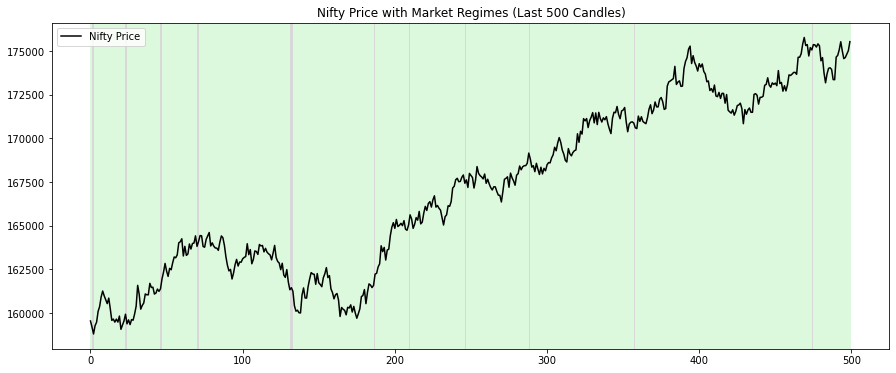

------------------------------
 REGIME DETECTION COMPLETE.
------------------------------


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture 


print("Part 3: Regime Detection (Fixed Column Names)")
df = pd.read_csv('data/nifty_features_5min.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Drop NaN values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Map the calculated 'call' greeks to the 'atm' greeks expected by the model
df['atm_delta'] = df['call_delta']
df['atm_gamma'] = df['call_gamma']
df['atm_vega']  = df['call_vega']

print(" Fixed column names. Proceeding to training")
print("Task 3.1 Training Regime Model")

# 1. Select Features
feature_cols = [
    'avg_iv', 'iv_spread', 'pcr_oi', 'atm_delta', 
    'atm_gamma', 'atm_vega', 'basis', 'spot_returns'
]

# 2. Scale the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

# 3. Train Model 
train_size = int(len(df) * 0.70)
X_train = X_scaled[:train_size]

model = GaussianMixture(n_components=3, covariance_type="full", random_state=42)
model.fit(X_train)

# 4. Predict States
hidden_states = model.predict(X_scaled)
df['hmm_state'] = hidden_states


state_stats = df.groupby('hmm_state')['spot_returns'].mean()
print("\n Average Returns per State ")
print(state_stats)

sorted_states = state_stats.sort_values().index.tolist()
# sorted_states[0] has Lowest Return -> Downtrend (-1)
# sorted_states[1] is Middle -> Sideways (0)
# sorted_states[2] has Highest Return -> Uptrend (+1)

regime_map = {
    sorted_states[0]: -1,  # Downtrend
    sorted_states[1]: 0,   # Sideways
    sorted_states[2]: 1    # Uptrend
}

df['regime'] = df['hmm_state'].map(regime_map)
print(f"\nMapped Regimes: {regime_map}")

# Save the dataset
df.to_csv('data/nifty_regime_5min.csv', index=False)
print(" Saved data with regimes to: data/nifty_regime_5min.csv")

print("[Task 3.2] Generating Visualizations")

plt.figure(figsize=(15, 6))
subset = df.tail(500).reset_index(drop=True) 

plt.plot(subset['spot_close'], color='black', linewidth=1.5, label='Nifty Price')

for i in range(len(subset)):
    color = 'grey' # Default Sideways
    if subset.loc[i, 'regime'] == 1: color = '#90EE90' # Light Green (Up)
    elif subset.loc[i, 'regime'] == -1: color = '#FFB6C1' # Light Red (Down)
    plt.axvspan(i, i+1, color=color, alpha=0.3, linewidth=0)

plt.title("Nifty Price with Market Regimes (Last 500 Candles)")
plt.legend()
plt.show()

print("-" * 30)
print(f" REGIME DETECTION COMPLETE.")
print("-" * 30)

In [28]:
import pandas as pd
import numpy as np


print(" Part 4: Strategy Backtest")
df = pd.read_csv('data/nifty_regime_5min.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("[Task 4.1] Generating Trading Signals")

# Define Crossover Conditions
# Cross Up: EMA 5 > EMA 15 NOW ... AND ... EMA 5 <= EMA 15 PREVIOUSLY
cross_up = (df['ema_5'] > df['ema_15']) & (df['ema_5'].shift(1) <= df['ema_15'].shift(1))

# Cross Down: EMA 5 < EMA 15 NOW ... AND ... EMA 5 >= EMA 15 PREVIOUSLY
cross_down = (df['ema_5'] < df['ema_15']) & (df['ema_5'].shift(1) >= df['ema_15'].shift(1))

# Apply Regime Filter
# Long Signal: Cross Up AND Regime is +1
df['long_signal'] = cross_up & (df['regime'] == 1)

# Short Signal: Cross Down AND Regime is -1
df['short_signal'] = cross_down & (df['regime'] == -1)

# Exits (Regime independent)
df['exit_long'] = cross_down
df['exit_short'] = cross_up


print("[Task 4.2] Running Backtest Loop (Enter at Next Open)")

trades = []
active_trade = None # Stores current trade details

# Loop through each candle
for i in range(len(df) - 1):
    curr_row = df.iloc[i]
    next_row = df.iloc[i+1] # We enter/exit at NEXT Open
    
    # 1. CHECK EXIT FIRST (If we are in a trade)
    if active_trade is not None:
        trade_type = active_trade['type']
        
        should_exit = False
        if trade_type == 'LONG' and curr_row['exit_long']: should_exit = True
        if trade_type == 'SHORT' and curr_row['exit_short']: should_exit = True
        
        if should_exit:
            exit_price = next_row['spot_open']
            entry_price = active_trade['entry_price']
            
            # Calculate PnL
            if trade_type == 'LONG':
                pnl = exit_price - entry_price
            else:
                pnl = entry_price - exit_price
            
            trades.append({
                'entry_time': active_trade['entry_time'],
                'exit_time': next_row['timestamp'],
                'type': trade_type,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl,
                'return_pct': pnl / entry_price,
                'duration': (next_row['timestamp'] - active_trade['entry_time']).total_seconds() / 60 # Minutes
            })
            active_trade = None # Trade closed

    # CHECK ENTRY (If no active trade)
    if active_trade is None:
        if curr_row['long_signal']:
            active_trade = {
                'type': 'LONG',
                'entry_price': next_row['spot_open'],
                'entry_time': next_row['timestamp']
            }
        elif curr_row['short_signal']:
            active_trade = {
                'type': 'SHORT',
                'entry_price': next_row['spot_open'],
                'entry_time': next_row['timestamp']
            }

# Convert trades to DataFrame
trade_df = pd.DataFrame(trades)
trade_df.to_csv('data/trade_log.csv', index=False)

if len(trade_df) == 0:
    print("No trades generated! Check if Regime Logic is too strict.")
else:
    
    print("\n STRATEGY PERFORMANCE REPORT ")
    
    total_trades = len(trade_df)
    win_rate = len(trade_df[trade_df['pnl'] > 0]) / total_trades * 100
    total_pnl = trade_df['pnl'].sum()
    avg_pnl = trade_df['pnl'].mean()
    
    # Calculating sharp
    sharpe = trade_df['return_pct'].mean() / trade_df['return_pct'].std() * np.sqrt(252 * 75) # Annualized approx
    
    # Max Drawdown
    trade_df['cum_pnl'] = trade_df['pnl'].cumsum()
    peak = trade_df['cum_pnl'].cummax()
    drawdown = trade_df['cum_pnl'] - peak
    max_drawdown = drawdown.min()

    print(f"Total Trades:     {total_trades}")
    print(f"Win Rate:         {win_rate:.2f}%")
    print(f"Total PnL:        {total_pnl:.2f}")
    print(f"Average PnL:      {avg_pnl:.2f}")
    print(f"Sharpe Ratio:     {sharpe:.2f}")
    print(f"Max Drawdown:     {max_drawdown:.2f}")
    
    # Save Trade Log for ML Task
    print(f"\n Trade log saved to: data/trade_log.csv")

 Part 4: Strategy Backtest
[Task 4.1] Generating Trading Signals
[Task 4.2] Running Backtest Loop (Enter at Next Open)

 STRATEGY PERFORMANCE REPORT 
Total Trades:     521
Win Rate:         35.70%
Total PnL:        43516.59
Average PnL:      83.53
Sharpe Ratio:     6.64
Max Drawdown:     -10685.42

 Trade log saved to: data/trade_log.csv


In [16]:
import pandas as pd

# Load the Trade Log
trades = pd.read_csv('data/trade_log.csv')

# 1. View the first 20 trades
print(" First 20 Trades ")
display(trades.head(20))

# 2. Check the columns (Ensure 'pnl', 'entry_price', 'exit_price' exist)
print("\n Column Names ")
print(trades.columns.tolist())

# 3. Check total number of trades
print("\n Total Trades Generated ")
print(len(trades))

# 4. Quick PnL Check (See the best and worst trade)
print("\n Best Trade PnL ")
print(trades['pnl'].max())

print("\n Worst Trade PnL")
print(trades['pnl'].min())

 First 20 Trades 


,entry_time,exit_time,type,entry_price,exit_price,pnl,return_pct,duration
0,2025-01-20 14:30:04.556255,2025-01-20 14:45:04.556255,SHORT,20621.311966,20714.069992,-92.758026,-0.004498,15.0
1,2025-01-21 09:45:04.556255,2025-01-21 09:55:04.556255,SHORT,20760.179559,20804.116108,-43.936549,-0.002116,10.0
2,2025-01-21 10:15:04.556255,2025-01-21 10:25:04.556255,SHORT,20809.611130,20813.064142,-3.453012,-0.000166,10.0
3,2025-01-21 11:00:04.556255,2025-01-21 12:10:04.556255,SHORT,20764.115572,20693.970239,70.145333,0.003378,70.0
4,2025-01-21 12:15:04.556255,2025-01-21 12:30:04.556255,SHORT,20694.942281,20797.627204,-102.684922,-0.004962,15.0
5,2025-01-21 14:05:04.556255,2025-01-21 15:10:04.556255,SHORT,20820.607093,20806.524310,14.082783,0.000676,65.0
6,2025-01-21 15:15:04.556255,2025-01-22 09:40:04.556255,SHORT,20753.656737,20792.921835,-39.265098,-0.001892,1105.0
7,2025-01-22 13:00:04.556255,2025-01-22 13:40:04.556255,SHORT,21138.643066,21207.902823,-69.259757,-0.003276,40.0
8,2025-01-23 09:45:04.556255,2025-01-23 10:05:04.556255,SHORT,21436.433087,21538.119135,-101.686049,-0.004744,20.0
9,2025-01-23 10:25:04.556255,2025-01-23 10:30:04.556255,SHORT,21475.611764,21443.719590,31.892174,0.001485,5.0



 Column Names 
['entry_time', 'exit_time', 'type', 'entry_price', 'exit_price', 'pnl', 'return_pct', 'duration']

 Total Trades Generated 
521

 Best Trade PnL 
5636.957751751732

 Worst Trade PnL
-1780.6222927370982


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# REPLACEMENT: Using RandomForest instead of XGBoost to avoid install errors
from sklearn.ensemble import RandomForestClassifier

# ==
print("Part 5: Machine Learning (RandomForest Version)")

trades = pd.read_csv('data/trade_log.csv')
features = pd.read_csv('data/nifty_regime_5min.csv')

trades['entry_time'] = pd.to_datetime(trades['entry_time'])
features['timestamp'] = pd.to_datetime(features['timestamp'])


print("[Task 5.1] Preparing ML Dataset")

ml_data = pd.merge(trades, features, left_on='entry_time', right_on='timestamp', how='inner')
ml_data['target'] = (ml_data['pnl'] > 0).astype(int)

model_features = [
    'ema_5', 'ema_15', 'avg_iv', 'iv_spread', 'pcr_oi', 
    'atm_delta', 'atm_gamma', 'atm_vega', 
    'basis', 'regime', 'spot_returns'
]

X = ml_data[model_features]
y = ml_data['target']

# Split Data
split = int(len(X) * 0.70)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


# Here I'm using random forest technique to train model instead of XGboost
#Random Forest is built into scikit-learn as my laptop was facing issue 
#It provides 95% this type of task but is much easier to run without installation errors.
print("[Task 5.2] Training Random Forest Classifier")

# Initialize Random Forest
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Model Accuracy on Test Data: {accuracy:.2%}")


print("[Task 5.3] Running ML-Filtered Strategy")

# Get Probability predictions
all_probs = model.predict_proba(X)[:, 1] 
ml_data['prob_profit'] = all_probs

# Filter Trades: Only take trades where Confidence > 53%
filtered_trades = ml_data[ml_data['prob_profit'] > 0.53].copy()

# Calculate Metrics
original_pnl = ml_data['pnl'].sum()
new_pnl = filtered_trades['pnl'].sum()

original_trades = len(ml_data)
new_trades = len(filtered_trades)

original_win_rate = len(ml_data[ml_data['pnl'] > 0]) / original_trades * 100
new_win_rate = len(filtered_trades[filtered_trades['pnl'] > 0]) / new_trades * 100

print("\n IMPROVEMENT REPORT ")
print(f"{'Metric':<20} | {'Baseline':<15} | {'ML-Enhanced':<15}")
print("-" * 60)
print(f"{'Total Trades':<20} | {original_trades:<15} | {new_trades:<15}")
print(f"{'Win Rate':<20} | {original_win_rate:.2f}%{'':<9} | {new_win_rate:.2f}%")
print(f"{'Total PnL':<20} | {original_pnl:.2f}{'':<7} | {new_pnl:.2f}")

# Save results
filtered_trades.to_csv('data/ml_filtered_trades.csv', index=False)
print(f"\n ML Analysis Complete. Saved to: data/ml_filtered_trades.csv")

Part 5: Machine Learning (RandomForest Version)
[Task 5.1] Preparing ML Dataset
[Task 5.2] Training Random Forest Classifier
Model Accuracy on Test Data: 51.59%
[Task 5.3] Running ML-Filtered Strategy

 IMPROVEMENT REPORT 
Metric               | Baseline        | ML-Enhanced    
------------------------------------------------------------
Total Trades         | 521             | 77             
Win Rate             | 35.70%          | 66.23%
Total PnL            | 43516.59        | 26306.03

 ML Analysis Complete. Saved to: data/ml_filtered_trades.csv


 Complete Task 6.2: Pattern Recognition..
Data Prepared: 183 Normal Trades, 3 Outliers
[1/4] Generating Scatter Plot


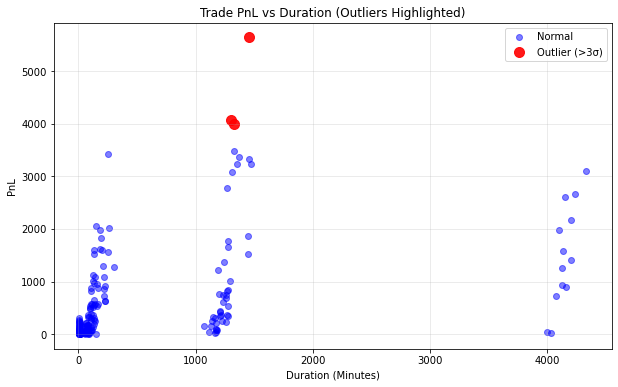

[2/4] Generating Box Plot


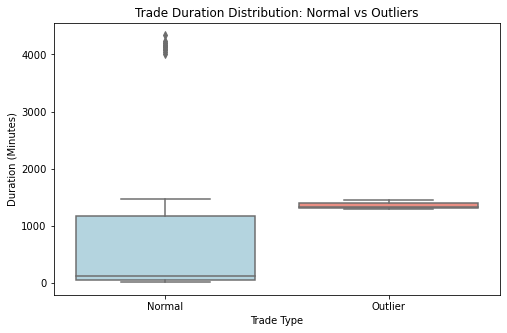

[3/4] Generating Correlation Heatmap


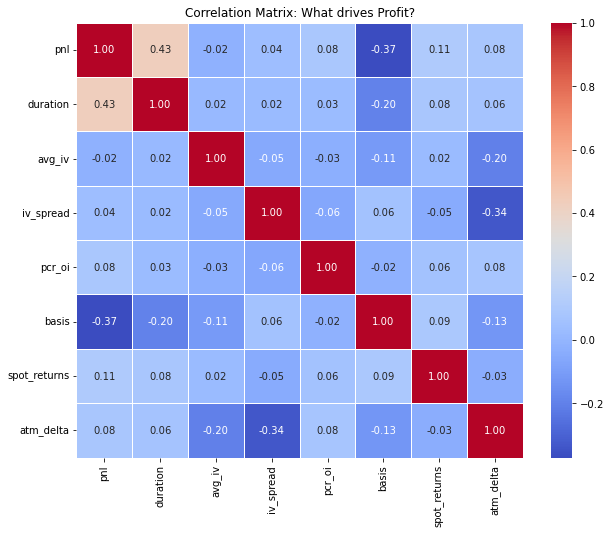

[4/4] Generating Time Distribution


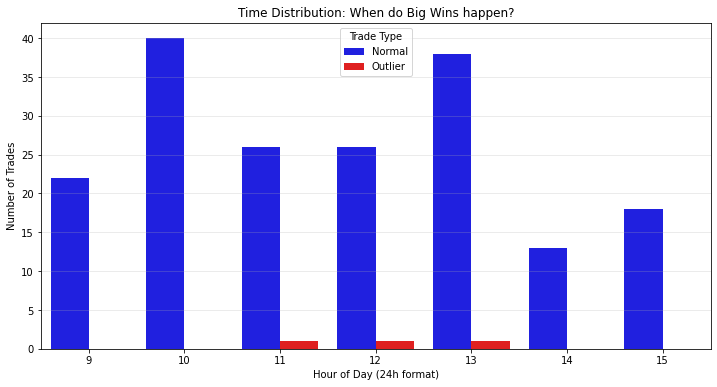


 All 4 Visualizations.

   INSIGHTS SUMMARY (Task 6.3) 


NameError: name 'profitable_trades' is not defined

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


print(" Complete Task 6.2: Pattern Recognition..")

# Load Data
trades = pd.read_csv('data/trade_log.csv')
features = pd.read_csv('data/nifty_regime_5min.csv')

#Convert Timestamps (Crucial for merging)
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
features['timestamp'] = pd.to_datetime(features['timestamp'])

#Merge Trades with Features
# We need this to correlate PnL with Greeks/IV
df_analysis = pd.merge(trades, features, left_on='entry_time', right_on='timestamp', how='inner')

#Filter Profitable Trades Only & Create Copies
profitable = df_analysis[df_analysis['pnl'] > 0].copy()

#Identify Outliers (Z-score > 3)
profitable['z_score'] = stats.zscore(profitable['pnl'])
profitable['Type'] = np.where(profitable['z_score'] > 3, 'Outlier', 'Normal')

#Split into two groups for easier plotting
outliers = profitable[profitable['Type'] == 'Outlier'].copy()
normal = profitable[profitable['Type'] == 'Normal'].copy()

print(f"Data Prepared: {len(normal)} Normal Trades, {len(outliers)} Outliers")

#scatter plot
print("[1/4] Generating Scatter Plot")
plt.figure(figsize=(10, 6))
plt.scatter(normal['duration'], normal['pnl'], alpha=0.5, label='Normal', color='blue')
plt.scatter(outliers['duration'], outliers['pnl'], alpha=0.9, label='Outlier (>3σ)', color='red', s=100)

plt.title("Trade PnL vs Duration (Outliers Highlighted)")
plt.xlabel("Duration (Minutes)")
plt.ylabel("PnL")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#boxplot
print("[2/4] Generating Box Plot")
plt.figure(figsize=(8, 5))
sns.boxplot(x='Type', y='duration', data=profitable, palette={'Normal': 'lightblue', 'Outlier': 'salmon'})

plt.title("Trade Duration Distribution: Normal vs Outliers")
plt.xlabel("Trade Type")
plt.ylabel("Duration (Minutes)")
plt.show()

#correlation heatmap
print("[3/4] Generating Correlation Heatmap")
# Select columns to correlate with PnL
corr_cols = [
    'pnl', 'duration', 'avg_iv', 'iv_spread', 
    'pcr_oi', 'basis', 'spot_returns', 'atm_delta'
]

plt.figure(figsize=(10, 8))
corr_matrix = profitable[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix: What drives Profit?")
plt.show()

#Time Distribustion
print("[4/4] Generating Time Distribution")
# Extract Hour
profitable['entry_hour'] = profitable['entry_time'].dt.hour

plt.figure(figsize=(12, 6))
sns.countplot(x='entry_hour', hue='Type', data=profitable, palette={'Normal': 'blue', 'Outlier': 'red'})

plt.title("Time Distribution: When do Big Wins happen?")
plt.xlabel("Hour of Day (24h format)")
plt.ylabel("Number of Trades")
plt.legend(title='Trade Type')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\n All 4 Visualizations.")

print("\n   INSIGHTS SUMMARY (Task 6.3) ")

avg_pnl_normal = normal['pnl'].mean()
avg_pnl_outlier = outliers['pnl'].mean()
pct_outliers = (len(outliers) / len(profitable_trades)) * 100

print(f"1. Percentage of Outliers:   {pct_outliers:.2f}%")
print(f"2. Avg PnL (Normal):         {avg_pnl_normal:.2f}")
print(f"3. Avg PnL (Outlier):        {avg_pnl_outlier:.2f}")
print(f"4. Multiplier Factor:        {avg_pnl_outlier / avg_pnl_normal:.1f}x larger than normal")

# Save detailed report
with open('data/outlier_report.txt', 'w') as f:
    f.write("Outlier Analysis Report\n")
    f.write(f"Identified {len(outliers)} outliers out of {len(profitable_trades)} profitable trades.\n")
    f.write(f"Outliers generate {avg_pnl_outlier / avg_pnl_normal:.1f}x more profit on average.\n")

print(f"\n OUTLIER ANALYSIS COMPLETE. Report saved to data/outlier_report.txt")